# Box Rectification & Augmentation *(debug v2)*

Extra diagnostics to explain **where cropping goes wrong** and to display key COCO fields for every patch:
* verbose per‑annotation banner with image/annotation IDs & bbox details
* lost‑pixels report when a crop gets clipped by image borders
* `inspect()` prints the category, bbox, rotation and lost‑pixel stats
* helper `overlay_bbox()` overlays the rotated‑back bbox for visual sanity checks


In [2]:
import cv2, os, math, sys
from pathlib import Path
from typing import List, Tuple
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO

VERBOSE = True

def debug(msg: str, level: str = 'INFO') -> None:
    if not VERBOSE:
        return
    colours = {'INFO': '\033[94m', 'WARN': '\033[93m', 'ERR': '\033[91m'}
    print(f"{colours.get(level, '')}[{level}] {msg}\033[0m")

## 1 · Configuration

In [14]:
SRC_IMG_DIR         = Path('../data/rotation/batches/batch_20250703_01/images/default')
SRC_ANNOTATION_PATH = Path('../data/rotation/batches/batch_20250703_01/annotations/instances_default.json')

DEST_IMG_DIR        = Path('../data/rotation/batches/batch_20250703_01/images/boxes')
DEST_IMG_DIR.mkdir(parents=True, exist_ok=True)

PAD_RATIO: float    = 1.05
ANGLES: List[int]   = [0, 45, 90, -45, -90, 180]

debug('Config loaded.')

[INFO] Config loaded.


## 2 · COCO helpers & utils

In [15]:
def load_coco(path: Path) -> COCO:
    debug(f'Loading COCO from {path}')
    return COCO(str(path))


def split_bbox(bbox: List[float]) -> Tuple[float, float, float, float, float]:
    if len(bbox) == 5:
        x, y, w, h, theta = bbox
    elif len(bbox) == 4:
        x, y, w, h = bbox; theta = 0.0
    else:
        debug(f'Unexpected bbox len={len(bbox)}', 'ERR'); raise ValueError(bbox)
    return x, y, w, h, float(theta)


def angle_from_ann(ann: dict) -> float:
    _, _, _, _, theta = split_bbox(ann['bbox'])
    if theta == 0.0:
        theta = float(ann.get('attributes', {}).get('rotation', 0.0))
        if theta > 180: theta -= 360
    return theta


def ensure_rgb(img):
    if img.ndim == 2: img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## 3 · Geometry with loss stats

In [16]:
def rectify_patch(img, cx, cy, w, h, theta, pad_ratio=PAD_RATIO):
    debug(f'Rectify: centre=({cx:.1f},{cy:.1f}) w={w:.1f} h={h:.1f} θ={theta:.1f}')
    M = cv2.getRotationMatrix2D((cx, cy), -theta, 1.0)
    rot = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    half_w, half_h = (w*pad_ratio)/2, (h*pad_ratio)/2
    x0, y0 = int(cx - half_w), int(cy - half_h)
    x1, y1 = int(cx + half_w), int(cy + half_h)

    lost_w = lost_h = 0
    if x0 < 0: lost_w += -x0; x0 = 0
    if y0 < 0: lost_h += -y0; y0 = 0
    if x1 > rot.shape[1]: lost_w += x1-rot.shape[1]; x1 = rot.shape[1]
    if y1 > rot.shape[0]: lost_h += y1-rot.shape[0]; y1 = rot.shape[0]

    patch = rot[y0:y1, x0:x1].copy()
    exp_w, exp_h = int(w*pad_ratio), int(h*pad_ratio)
    debug(f'Patch {patch.shape} expected≈({exp_h},{exp_w}) lost ({lost_w}px, {lost_h}px)')
    return patch, (lost_w, lost_h)

In [17]:
def rotate_patch(patch, angle):
    h, w = patch.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    cos, sin = abs(M[0,0]), abs(M[0,1])
    new_w, new_h = int(h*sin + w*cos), int(h*cos + w*sin)
    M[0,2] += new_w/2 - w/2
    M[1,2] += new_h/2 - h/2
    return cv2.warpAffine(patch, M, (new_w, new_h), flags=cv2.INTER_LINEAR, borderValue=255)

## 4 · Save helper

In [18]:
def save_patch(patch, dest: Path):
    dest.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(dest), patch)

## 5 · Overlay helper (optional)

In [ ]:
def overlay_bbox(img, cx, cy, w, h, theta, color=(0,255,0)):
    # Draw rectangle before rotation (for debug)
    pts = np.array([
        [-w/2, -h/2], [w/2, -h/2], [w/2, h/2], [-w/2, h/2]
    ])
    rad = np.deg2rad(theta)
    R = np.array([[math.cos(rad), -math.sin(rad)], [math.sin(rad), math.cos(rad)]])
    rot_pts = (pts @ R.T) + np.array([cx, cy])
    rot_pts = rot_pts.astype(int)
    
    for i in range(4):
        p1, p2 = rot_pts[i], rot_pts[(i+1)%4]
        cv2.line(img, tuple(p1), tuple(p2), color, 2)
    return img

## 6 · Main loop with extra prints

In [19]:
def process_dataset(src_img_dir: Path, coco_json: Path, dest_img_dir: Path,
                    angles: List[int] = ANGLES, every: int = 200):
    coco = load_coco(coco_json)
    cats = {c['id']: c['name'] for c in coco.loadCats(coco.getCatIds())}
    id2path = {img['id']: src_img_dir / img['file_name'] for img in coco.dataset['images']}

    for idx, ann in enumerate(tqdm(coco.dataset['annotations'], desc='Extracting')):
        img_path = id2path[ann['image_id']]
        img = cv2.imread(str(img_path))
        if img is None:
            debug(f'Cannot read {img_path}', 'WARN'); continue

        x, y, w, h, _ = split_bbox(ann['bbox'])
        cx, cy = x+w/2, y+h/2
        theta = angle_from_ann(ann)
        cat_name = cats.get(ann['category_id'], '?')
        debug(f'IMG {ann["image_id"]} {img_path.name} | ANN {ann["id"]} cat={cat_name}')
        patch, loss = rectify_patch(img, cx, cy, w, h, theta)

        base = f"{img_path.stem}_ann{ann['id']:06d}"
        save_patch(patch, dest_img_dir / f"{base}_000deg.png")
        for a in angles:
            if a == 0: continue
            save_patch(rotate_patch(patch, a), dest_img_dir / f"{base}_{a:+03d}deg.png")

        if (idx+1) % every == 0:
            debug(f'Processed {idx+1}/{len(coco.dataset["annotations"])}')

## 7 · Interactive inspect()

In [20]:
def inspect(image_id: int, ann_id: int = None):
    import matplotlib.pyplot as plt
    coco = load_coco(SRC_ANNOTATION_PATH)
    cats = {c['id']: c['name'] for c in coco.loadCats(coco.getCatIds())}

    img_info = coco.loadImgs([image_id])[0]
    img = cv2.imread(str(SRC_IMG_DIR / img_info['file_name']))
    anns = coco.loadAnns(coco.getAnnIds(imgIds=[image_id]))
    ann = coco.loadAnns([ann_id])[0] if ann_id else anns[0]

    x, y, w, h, _ = split_bbox(ann['bbox'])
    theta = angle_from_ann(ann)
    patch, loss = rectify_patch(img, x+w/2, y+h/2, w, h, theta)

    print('--- IMAGE ---')
    print(f'ID      : {img_info["id"]}')
    print(f'Filename: {img_info["file_name"]}')
    print(f'Size    : {img_info["width"]}×{img_info["height"]}')
    print('\n--- ANNOTATION ---')
    print(f'ID        : {ann["id"]}')
    print(f'Category   : {ann["category_id"]} ({cats.get(ann["category_id"], "?")})')
    print(f'BBox(x,y,w,h,θ): {ann["bbox"]}')
    print(f'Rotation attr   : {ann.get("attributes", {}).get("rotation", "∅")}')
    print(f'Lost pixels     : width={loss[0]} height={loss[1]}')

    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(ensure_rgb(img)); ax[0].set_title('Original'); ax[0].axis('off')
    overlay = img.copy()
    overlay_bbox(overlay, x+w/2, y+h/2, w, h, theta, color=(0,0,255))
    ax[0].imshow(ensure_rgb(overlay))
    ax[1].imshow(ensure_rgb(patch)); ax[1].set_title('Rectified'); ax[1].axis('off')
    plt.tight_layout()

## 8 · Smoke test

[INFO] Loading COCO from ../data/rotation/batches/batch_20250703_01/annotations/instances_default.json
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
[INFO] Rectify: centre=(1865.0,307.0) w=47.3 h=39.8 θ=0.0
[INFO] Patch (41, 49, 3) expected≈(41,49) lost (0px, 0px)
--- IMAGE ---
ID      : 44
Filename: 10108.png
Size    : 2160×3054

--- ANNOTATION ---
ID        : 1942
Category   : 7 (text)
BBox(x,y,w,h,θ): [1841.3, 287.1, 47.3, 39.8]
Rotation attr   : 0.0
Lost pixels     : width=0 height=0


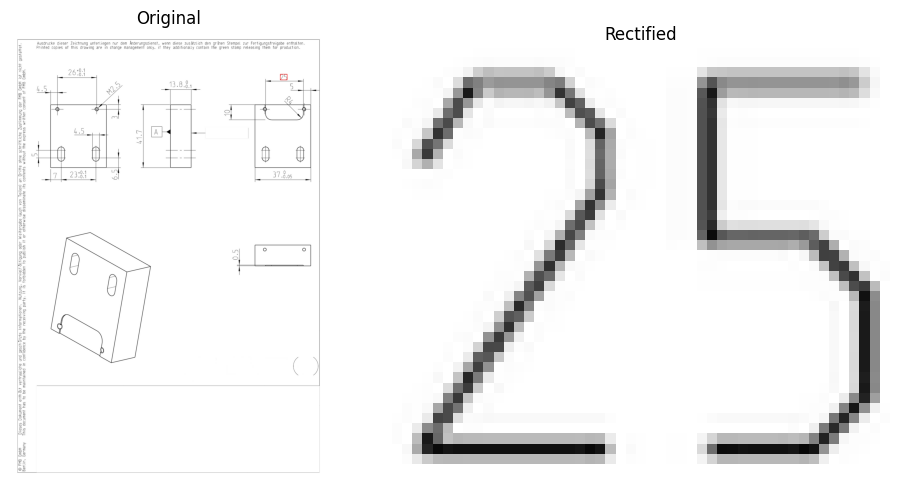

In [31]:
inspect(image_id=44)

## 9 · Run full dataset

In [12]:
# VERBOSE = False  # uncomment for speed
# process_dataset(SRC_IMG_DIR, SRC_ANNOTATION_PATH, DEST_IMG_DIR)